<a href="https://colab.research.google.com/github/swampxx/sciann-examples/blob/main/sciann_poisson_L_shape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install sciann
%%capture sciann_installation
!pip install sciann

In [ ]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt

import sciann as sn

%matplotlib inline

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


In this notebook, we solve the Poisson equation over an L-shaped domain $\Omega = [-1, 1]^2 \backslash [0, 1]^2$:

$-\Delta u(x,y) = 1, (x,y) \in \Omega$

The boundary conditions:

$u(x,y) = 0, (x,y) \in \partial \Omega$




In [ ]:
# Define the L-shape domain

x_data_1, y_data_1 = np.meshgrid(
    np.linspace(-1, 1, 100), 
    np.linspace(0, -1, 50)
)

x_data_2, y_data_2 = np.meshgrid(
    np.linspace(-1, 0, 50), 
    np.linspace(0,  1, 50)
)

In [ ]:
# Prepare training data

x_data = np.concatenate([x_data_1.flatten(), x_data_2.flatten()])
y_data = np.concatenate([y_data_1.flatten(), y_data_2.flatten()])

In [ ]:
# Define Input variables x, y

x = sn.Variable('x')
y = sn.Variable('y')

# Define the underlying network
u = sn.Functional('u', [x, y], 8*[20], 'tanh')

In [ ]:
# The governing equation
L1 = -sn.diff(u, x, order=2)- sn.diff(u, y, order=2) -1

# Impose boundary conditions
TOL = 0.001

C1 = (1 - sn.sign(x+1 - TOL))*u
C2 = (1 + sn.sign(x-1 + TOL))*u
C3 = (1 + sn.sign(y-1 + TOL))*u
C4 = (1 - sn.sign(y+1 - TOL))*u
C5 = (1 + sn.sign(x + TOL))*(1 + sn.sign(y + TOL))*u

In [ ]:
# Construct SciANN Model
model = sn.SciModel([x, y], [L1, C1, C2, C3, C4, C5])

In [ ]:
# Training
history = model.train([x_data, y_data], 6*['zeros'], learning_rate=0.002, epochs=5000, batch_size=256, verbose=2)

In [ ]:
# Genereate predictions
u_pred = u.eval(model, [x_data, y_data])

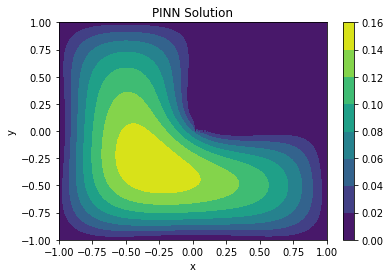

In [ ]:
# Plotting

# fill empty places with 0s
empty_points_x, empty_points_y = np.meshgrid(
    np.linspace(0, 1, 50), 
    np.linspace(0, 1, 50)
)

empty_points_x = empty_points_x.flatten()
empty_points_y = empty_points_y.flatten()

empty_u = np.zeros(50*50)

# prepare pre
plot_u_pred = u_pred.copy()
plot_u_pred = np.concatenate([np.where(plot_u_pred>=0, plot_u_pred, 0), empty_u])

plot_x = np.concatenate([x_data, empty_points_x])
plot_y = np.concatenate([y_data, empty_points_y])

plt.title('PINN Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.tricontourf(plot_x, plot_y, plot_u_pred)
plt.colorbar()
plt.show()